In [1]:
import math
from typing import List, Optional, Tuple, Union
import sys
from PIL import Image
from pathlib import Path
import torch
import os
from accelerate import Accelerator
from torch import nn
from transformers import (
    AutoModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
    RobertaModel,
    RobertaConfig,
)
from sklearn.model_selection import train_test_split
import os
from tqdm.notebook import tqdm
import numpy as np
import torch.nn as nn
from dataclasses import dataclass
from typing import Any, Dict, Generator, List, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
import pandas as pd

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings

warnings.simplefilter("ignore")
from transformers import ViTFeatureExtractor, ViTModel

2024-05-28 10:47:41.930876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 10:47:41.930971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 10:47:42.062042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00


In [3]:
from einops import rearrange

In [4]:
class RotaryEmbedding(nn.Module):
    """Construct the positionl frequencies for RoPE embedding"""

    def __init__(self, config, base=10000, device=None):
        super().__init__()

        self.dim = int(config.hidden_size // config.num_attention_heads)
        self.max_position_embeddings = config.max_position_embeddings
        self.base = base
        self.register_buffer(
            "inv_freq",
            1.0
            / (
                self.base
                ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim)
            ),
            persistent=False,
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )

    @torch.no_grad()
    def forward(self, seq_len: int = None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # size = x.size()[2]
        position_ids = torch.arange(seq_len).unsqueeze(0)
        # position_ids = self.position_ids[:, :size].float()

        inv_freq_expanded = (
            self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        )
        position_ids_expanded = position_ids[:, None, :].float()

        freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(
            1, 2
        )
        return freqs


# Copied from transformers
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, freqs, unsqueeze_dim=1) -> Tuple[torch.Tensor]:
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        freqs: precalculated frqs for sin cos
        only_q: bool = False for encoder decoder
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    emb = torch.cat((freqs, freqs), dim=-1)
    cos = emb.cos().to(dtype=q.dtype)
    sin = emb.sin().to(dtype=q.dtype)
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)

    q_embed = (q * cos) + (rotate_half(q) * sin)

    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [5]:
_ACT_ = {
    "gelu": nn.GELU(),
    "leaky_relu": nn.LeakyReLU(),
    "relu6": nn.ReLU6(),
    "sigmoid": nn.Sigmoid(),
    "silu": nn.SiLU(),
    "swish": nn.SiLU(),
    "tanh": nn.Tanh(),
}


class FeedForward(nn.Module):
    def __init__(self, config, multiplier: Union[int, float] = 4) -> None:
        super().__init__()
        intermediate_size = getattr(config, "intermediate_size", None)
        self.intermediate_size = (
            int(multiplier) * config.hidden_size
            if intermediate_size is None
            else intermediate_size
        )

        self.intermediate = nn.Linear(config.hidden_size, self.intermediate_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        if _ACT_.get(getattr(config, "hidden_act", None), None):
            self.act_fn = _ACT_[config.hidden_act]
        else:
            self.act_fn = nn.GELU()
        self.out = nn.Linear(self.intermediate_size, config.hidden_size)

    def forward(
        self, hidden_state: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        output = self.intermediate(hidden_state)
        output = self.act_fn(output)
        output = self.out(output)
        output = self.dropout(output)
        output = self.layernorm(output + input_tensor)
        return output

In [6]:
class AbsoluteEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.pos_embeddings = nn.Embedding(
            config.max_position_embeddings,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )
        self.max_size = config.max_position_embeddings

    def forward(self, size: int) -> torch.Tensor:
        if self.max_size < size:
            raise ValueError(
                f"The hidden size ({size }) is more than the config max_position_embeddings {self.max_size}"
            )
        return self.pos_embeddings(self.position_ids[:, :size])


_position_embeddings = {"absolute": AbsoluteEncoding}

In [7]:
def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(
        batch, num_key_value_heads, n_rep, slen, head_dim
    )
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


class AttentionSelfOutput(nn.Module):
    def __init__(self, config, bias: Optional[bool] = True):
        super().__init__()
        self.dense = nn.Linear(
            config.hidden_size,
            config.hidden_size,
            bias=bias,
        )
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self, hidden_states: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.layernorm(hidden_states + input_tensor)
        return hidden_states


class DecoderAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        # self.qkv = nn.Linear(config.hidden_size,3*config.hidden_size)
        self.query = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.key = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.value = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.out = AttentionSelfOutput(config=config, bias=self.attention_bias)
        self.num_attention_heads = config.num_attention_heads

        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
        if not self.flash and self.layer_idx == 0:  # avoid to print m times:
            print("WARNING: Flash Attention requires PyTorch >= 2.0")

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> Tuple[torch.Tensor, object]:
        q = self.query(hidden_state)
        k = self.key(hidden_state)
        v = self.value(hidden_state)
        # q,k,v = self.qkv(hidden_state).chunk(3, dim = -1) #b X l X d dim =-1 or 2
        # place holder for RoPe operation
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)
        k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
        v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)

        if freqs is not None:
            q, k = apply_rotary_pos_emb(q, k, freqs)

        if use_cache:
            cache = getattr(self, "cache", None)
            if cache is None:
                raise ValueError(
                    "you need to setup cache for every attention layer with model.setup_cache()"
                )
            k, v = cache.update(k, v, start_pos)

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask
        )
        out = rearrange(out, "b h l d -> b l (h d)")

        return self.out(out, hidden_state)

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, config, layer_idx: int = 0, attention_type: str = None) -> None:
        super().__init__()
        self.attention = (
            DecoderAttentionGqa(config, layer_idx=layer_idx)
            if attention_type == "gqa"
            else DecoderAttention(config, layer_idx=layer_idx)
        )
        if attention_type == "gqa" and layer_idx == 0:  # avoid to print m times
            print("Decoder Using GQA Attention")
        if attention_type == "gqa" and layer_idx == 0:  # avoid to print m times
            print("Using GQA in Cross Attention")
        self.feed_forward = FeedForward(config)
        self.layer_idx = layer_idx

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        out = self.attention(
            hidden_state=hidden_state,
            attention_mask=attention_mask,
            freqs=freqs,
            use_cache=use_cache,
            start_pos=start_pos,
        )

        out = self.feed_forward(out, hidden_state)
        return out


class LMHead(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.vocab = nn.Linear(config.hidden_size, config.vocab_size)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        self.vocab.bias = self.bias

    def forward(self, hidden_state: torch.Tensor) -> torch.Tensor:
        x = self.dense(hidden_state)
        x = nn.GELU()(x)
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.vocab(x)

        return x

In [9]:
@dataclass
class DecoderOutput(object):
    logits: torch.Tensor


class LMHead(nn.Module):
    """Head for masked language modelling"""

    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.vocab = nn.Linear(config.hidden_size, config.vocab_size)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        self.vocab.bias = self.bias

    def forward(self, hidden_state: torch.Tensor) -> torch.Tensor:
        x = self.dense(hidden_state)
        x = nn.GELU()(x)
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.vocab(x)

        return x


class DecoderModel(nn.Module):
    def __init__(
        self,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> None:
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        if _position_embeddings.get(pos_embedding_type, None) is not None:
            self.position_embeddings = _position_embeddings.get(pos_embedding_type)(
                config
            )
        else:
            self.position_embeddings = None
        if pos_embedding_type == "rope":
            self.emb_freq = RotaryEmbedding(config)(config.max_position_embeddings)
            print(
                "Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable"
            )
        self.all_layer = nn.ModuleList(
            [
                DecoderLayer(config, layer_idx, attention_type=attention_type)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / torch.sqrt(2 * len(self.all_layer))
            )
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / torch.sqrt(2 * len(self.all_layer))
            )

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        encoder_hidden_state: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        _bsz, seqlen = input_ids.shape
        hidden_state = self.word_embeddings(input_ids)
        if start_pos == 0:
            hidden_state = torch.cat(
                [encoder_hidden_state.unsqueeze(1), hidden_state], dim=1
            )
            if attention_mask is not None:
                extra_token = torch.full((_bsz, 1), 1).to(input_ids.device)
                attention_mask = torch.cat([extra_token, attention_mask], dim=1)
        freqs = None
        _bsz, seqlen, _ = hidden_state.shape
        if self.position_embeddings is not None:
            pos_info = pos_info = self.position_embeddings(start_pos + seqlen)[
                :, start_pos : start_pos + seqlen, :
            ].to(input_ids.device)
            hidden_state = hidden_state + pos_info
        else:
            freqs = self.emb_freq[:, start_pos : start_pos + seqlen].to(
                input_ids.device
            )

        mask = None
        if seqlen > 1:
            mask = self.create_mask_for_decoder(
                hidden_state=hidden_state,
                attention_mask=attention_mask,
                start_pos=start_pos,
            )
            mask = (1.0 - mask) * torch.finfo(
                hidden_state.dtype
            ).min  # invert it to to add directly to attention score

        for layer in self.all_layer:
            hidden_state = layer(
                hidden_state=hidden_state,
                attention_mask=mask,
                freqs=freqs,
                use_cache=use_cache,
                start_pos=start_pos,
            )
        return hidden_state

    def create_mask_for_decoder(
        self,
        hidden_state: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        device = hidden_state.device
        batch_size, seq_length, _ = hidden_state.shape
        if attention_mask is None:
            attention_mask = (
                torch.ones(seq_length + start_pos).repeat(batch_size, 1).to(device)
            )
        seq_ids = torch.arange(seq_length).to(device)
        causal_mask = (
            seq_ids[None, None, :].repeat(batch_size, seq_length, 1)
            <= seq_ids[None, :, None]
        )  # 1x1xl repeat bxlxl compare to 1xlx1

        causal_mask = causal_mask.to(attention_mask.dtype)

        if start_pos > 0:  # correct the attention mask  for kv-cache operation
            causal_mask = torch.cat(
                [
                    torch.ones(
                        (batch_size, seq_length, start_pos),
                        device=device,
                        dtype=causal_mask.dtype,
                    ),
                    causal_mask,
                ],
                axis=-1,
            )

        extended_attention_mask = (
            causal_mask[:, None, :, :] * attention_mask[:, None, None, :]
        )  # this is mainly if batch contains <PAD> tokens. stop casual procees before <PAD>
        return extended_attention_mask

    @classmethod
    def from_config(cls, config) -> nn.Module:
        return cls(config)

In [10]:
# mainly 2way to do one keep it into the model init like llama https://github.com/meta-llama/llama/blob/main/llama/model.py
# every attention layer have its own kv-cache storage
# or keep all attention layer kv-cache into single storage like Huggingface Transformer


from dataclasses import dataclass
from typing import Any, Dict, Generator, List, Optional, Tuple
import torch


class DynamicCache:
    """
    A cache that grows dynamically as more tokens are generated. This is the default for generative models.

    It stores the Key and Value states as a list of tensors, one for each layer. The expected shape for each tensor is
    `[batch_size, num_heads, seq_len, head_dim]`.
    """

    def __init__(self, config, is_gqa: Optional[bool] = False) -> None:
        self.key_cache: torch.Tensor = None
        self.value_cache: torch.Tensor = None
        self._seen_tokens = False
        self.maxlen = config.max_position_embeddings

    def __len__(self) -> int:
        if self.key_cache is None:
            return 0
        """
        Support for backwards-compatible `past_key_value` length, e.g. `len(past_key_value)`. This value corresponds
        to the number of layers in the model.
        """
        return self.key_cache.shape[-2]

    def update(
        self, key_states: torch.Tensor, value_states: torch.Tensor, start_pos: int = 0
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Updates the cache with the new `key_states` and `value_states` for the layer `layer_idx`.

        Parameters:
            key_states (`torch.Tensor`):
                The new key states to cache.
            value_states (`torch.Tensor`):
                The new value states to cache.
            layer_idx (`int`):
                The index of the layer to cache the states for.
            cache_kwargs (`Dict[str, Any]`, `optional`):
                Additional arguments for the cache subclass. No additional arguments are used in `DynamicCache`.

        Return:
            A tuple containing the updated key and value states.
        """

        # Update the cache first iteration
        if self.key_cache is None:
            self._seen_tokens = True
            self.key_cache = key_states.clone()
            self.value_cache = value_states.clone()
        else:
            self.key_cache = torch.cat([self.key_cache, key_states], dim=-2)
            self.value_cache = torch.cat([self.value_cache, value_states], dim=-2)

        return self.key_cache, self.value_cache

    def get(self) -> Tuple[torch.Tensor]:
        if self._seen_tokens:
            return self.key_cache, self.value_cache
        else:
            raise ValueError("there is no token available in kv-cache")

    def get_seq_length(self, layer_idx: Optional[int] = 0) -> int:
        """Returns the sequence length of the cached states. A layer index can be optionally passed."""
        if self.key_cache is None:
            return 0
        return self.key_cache.shape[-2]

    def get_max_length(self) -> Optional[int]:
        """Returns the maximum sequence length of the cached states. DynamicCache does not have a maximum length."""
        return None


class StaticCache:
    """
    A cache that is size fixed suitable for torch.compile

    It stores the Key and Value states as a list of tensors, one for each layer. The expected shape for each tensor is
    `[batch_size, num_heads, seq_len, head_dim]`.
    """

    def __init__(self, config, is_gqa: Optional[bool] = False) -> None:
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.heads = None
        if is_gqa:
            self.heads = getattr(config, "num_key_value_heads", None)
            if self.heads is None:
                raise ValueError(
                    "you are using is_gqa=True and config.num_key_value_heads is not available"
                )
        if self.heads is None:

            self.heads = config.num_attention_heads

        self.key_cache: torch.Tensor = torch.zeros(
            1,
            self.heads,
            config.max_position_embeddings,
            self.head_size,
        )
        self.value_cache: torch.Tensor = torch.zeros(
            1,
            self.heads,
            config.max_position_embeddings,
            self.head_size,
        )
        self._seen_tokens = False

    def update(
        self, k: torch.Tensor, v: torch.Tensor, start_pos: int = 0
    ) -> Tuple[torch.Tensor]:
        self._seen_tokens = True
        bsz, head, seqlen, _ = k.shape
        self.first_update_len = seqlen
        if seqlen > self.key_cache.size()[2]:
            raise ValueError(
                f"{k.shape} is more than init k_cache size {self.key_cache}"
            )

        assert bsz == 1, "Only support batch size 1"

        self.key_cache = self.key_cache.to(k)
        self.value_cache = self.value_cache.to(v)

        self.key_cache[:bsz, :, start_pos : start_pos + seqlen] = k
        self.value_cache[:bsz, :, start_pos : start_pos + seqlen] = v

        k = self.key_cache[:bsz, :, : start_pos + seqlen]
        v = self.value_cache[:bsz, :, : start_pos + seqlen]

        return k, v

    def get(self) -> Tuple[torch.Tensor]:
        if self._seen_tokens:
            k = self.key_cache[:, :, : self.first_update_len]
            v = self.value_cache[:, :, : self.first_update_len]

            return k, v
        else:
            raise ValueError("there is no token available in kv-cache")

    def __len__(self) -> int:
        if self._seen_tokens == False:
            return 0
        """
        Support for backwards-compatible `past_key_value` length, e.g. `len(past_key_value)`. This value corresponds
        to the number of layers in the model.
        """
        return self.key_cache.shape[2]

In [11]:
class VisionLanguageModel(nn.Module):

    def __init__(
        self,
        encoder,
        decoder_config,
        decoder_pos_embedding_type: Optional[str] = "absolute",
        decoder_attention_type: str = None,
    ) -> None:
        super().__init__()
        self.is_gqa = True if decoder_attention_type == "gqa" else False
        self.encoder = encoder
        self.decoder = DecoderModel(
            config=decoder_config,
            pos_embedding_type=decoder_pos_embedding_type,
            attention_type=decoder_attention_type,
        )
        self.lm_head = LMHead(config=decoder_config)

    def forward(
        self,
        pixel_values: Optional[torch.LongTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        encoder_output: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ):
        if encoder_output is None:
            encoder_output = self.encoder(pixel_values=pixel_values).last_hidden_state[
                :, 0, :
            ]  # get cls token information

        decoder_output = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_state=encoder_output,
            use_cache=use_cache,
            start_pos=start_pos,
        )
        decoder_output = self.lm_head(decoder_output)
        return DecoderOutput(logits=decoder_output)

    def get_decoder(self) -> DecoderModel:
        return self.decoder

    def get_encoder_output(self, pixel_values: torch.Tensor) -> object:
        return self.encoder(pixel_values=pixel_values).last_hidden_state[:, 0, :]

    def _setup_cache(self, config, cls: Optional[object] = StaticCache) -> None:
        for layer in self.decoder.all_layer:
            layer.attention.cache = cls(config, is_gqa=self.is_gqa)

    def _clean_cache(self) -> None:
        for layer in self.decoder.all_layer:
            layer.attention.cache = None

    @classmethod
    def from_config(
        cls,
        encoder,
        decoder_config,
        decoder_pos_embedding_type: Optional[str] = "absolute",
        decoder_attention_type: str = None,
    ) -> nn.Module:
        return cls(
            encoder,
            decoder_config,
            decoder_pos_embedding_type,
            decoder_attention_type,
        )

In [12]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config = RobertaConfig.from_pretrained(model_ckpt)
# config.num_key_value_heads = 4

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

**Using pretrained Vit model for speeding up the convergence you can use pretrained CLIP image encoder model also.**


**You can also use raw Vit/Clip model see the previous  examples on how to create Vit/Clip**

In [14]:
vit_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
multimodel = VisionLanguageModel(vit_encoder, config, decoder_pos_embedding_type="rope")
# roberta.encoder.layer.0.attention.self.query.weight

Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable


In [16]:
multimodel

VisionLanguageModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768

In [17]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`


**using the pretrained roberta model embedding for faster convergence**

In [19]:
multimodel.decoder.word_embeddings.weight = (
    model.roberta.embeddings.word_embeddings.weight
)


# multimodel.decoder.position_embeddings.pos_embeddings.weight = model.roberta.embeddings.position_embeddings.weight

In [20]:
del model

In [21]:
class ImgDataset(Dataset):
    def __init__(self, df, root_dir, tokenizer, feature_extractor, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50

    def __len__(
        self,
    ):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir, image)
        img = Image.open(img_path).convert("RGB")

        #         if self.transform is not None:
        #             img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        text = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            add_special_tokens=False,
            truncation=True,
        )
        captions = text.input_ids
        captions = [
            caption if caption != self.tokenizer.pad_token_id else -100
            for caption in captions
        ]
        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(captions),
            "decoder_attention_mask": torch.tensor(text.attention_mask),
        }
        return encoding

In [22]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [23]:
df = pd.read_csv("../input/flickr30k/captions.txt")

In [24]:
df = df.dropna()

In [25]:
df.shape

(158914, 2)

In [26]:
# df=  pd.read_csv("../input/flickr30k/captions.txt")
# df = df.sample(frac=0.2, random_state=42)
# dff.shape
train_df, val_df = train_test_split(df, test_size=0.15)
# df.head()
train_dataset = ImgDataset(
    train_df,
    root_dir="../input/flickr30k/Images",
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
)
val_dataset = ImgDataset(
    val_df,
    root_dir="../input/flickr30k/Images",
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [27]:
def collate(input_ids):
    #     input_ids.masked_fill_(input_ids == tokenizer.pad_token_id,-100 )
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[..., 1:] = input_ids[..., :-1].clone()
    shifted_input_ids[..., 0] = tokenizer.cls_token_id

    if tokenizer.pad_token_id is None:
        raise ValueError("tokenizer.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`

    shifted_input_ids.masked_fill_(shifted_input_ids == -100, tokenizer.pad_token_id)

    return shifted_input_ids

In [28]:
def loss_fn(prediction_scores, labels):
    bsz, seqlen = labels.shape
    ignore_label = torch.full((bsz, 1), -100, dtype=torch.long).to(labels.device)
    labels = torch.cat([ignore_label, labels], dim=1)

    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)

    lm_loss = loss_fct(prediction_scores.view(-1, config.vocab_size), labels.view(-1))
    return lm_loss

In [34]:
def validation(model, val_loader=val_loader):
    model.eval()
    all_loss = 0.0
    for step, data in tqdm(enumerate(val_loader)):
        decoder_input_ids = collate(data["labels"])
        pixel_values = data["pixel_values"].to(device)
        with torch.no_grad():
            pred = multimodel(
                pixel_values=pixel_values,
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=data["decoder_attention_mask"].to(device),
            )
        loss = loss_fn(pred.logits, data["labels"].to(device))
        all_loss += loss.detach().cpu().item()
    print("validation_loss = ", all_loss / len(val_loader))

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def single_gpu():

    accumulation_steps = 1  # batch size 64 large dont need gradient accumulation

    lr = 5e-5

    EPOCHS = 5

    Config = {
        "num_epoch": EPOCHS,
        "learning_rate": lr,
        "loss_function": str(torch.nn.CrossEntropyLoss),
    }

    accelerator = Accelerator(
        log_with="tensorboard",
        project_dir=".",
    )

    accelerator.init_trackers("multimodel_project", config=Config)

    no_decay = ["bias", "layernorm.weight", "layernorm.bias"]

    optimizer_grouped_parameters = [
        {
            "params": [
                p
                for n, p in multimodel.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [
                p
                for n, p in multimodel.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)

    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)

    #     optimizer = torch.optim.AdamW(ptimizer_grouped_parameters, lr = lr)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.05 * num_train_optimization_steps,
        num_training_steps=num_train_optimization_steps,
    )

    multimodel.to(device)

    epoch_check = len(train_loader)

    total_step = epoch_check * EPOCHS

    train_bar = tqdm(total=total_step, dynamic_ncols=True)

    t_step = 1

    k = 0

    for epoch in range(EPOCHS):
        multimodel.train()

        avg_loss = 0.0

        loss_list = []

        running_loss = 0.0

        for step, data in enumerate(train_loader):

            train_bar.update(1)

            decoder_input_ids = collate(data["labels"])

            pixel_values = data["pixel_values"].to(device)

            optimizer.zero_grad()

            pred = multimodel(
                pixel_values=pixel_values,
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=data["decoder_attention_mask"].to(device),
            )

            loss = loss_fn(pred.logits, data["labels"].to(device))

            loss.backward()

            optimizer.step()

            scheduler.step()

            accelerator.log({"training_loss_step": loss}, step=t_step)

            train_bar.set_description(
                f'epoch: {epoch+1} step: {t_step} loss: {"%.4f" % loss}'
            )

            t_step += 1

            loss_list.append(loss.detach().cpu().item())

        #         scheduler.step()

        avg_loss = np.round(np.mean(loss_list), 4)

        accelerator.log({"training_loss_epoch": avg_loss}, step=epoch + 1)

        print(f'Epoch: {epoch+1} loss: {"%.4f" % avg_loss }')

        validation(multimodel)

    accelerator.end_training()

    PATH = f"vit_language_multimodel{epoch}.pth"

    torch.save(multimodel.state_dict(), PATH)

**This is just to show how things work under the hood for multimodel.**


**large amount of data and big model  can improve results further.**

In [36]:
single_gpu()

  0%|          | 0/21110 [00:00<?, ?it/s]

Epoch: 1 loss: 4.0451


0it [00:00, ?it/s]

validation_loss =  3.049729761341274
Epoch: 2 loss: 2.7923


0it [00:00, ?it/s]

validation_loss =  2.7242668065448736
Epoch: 3 loss: 2.4513


0it [00:00, ?it/s]

validation_loss =  2.5907618567447535
Epoch: 4 loss: 2.2093


0it [00:00, ?it/s]

validation_loss =  2.5367111727695337
Epoch: 5 loss: 2.0288


0it [00:00, ?it/s]

validation_loss =  2.5285525254755212


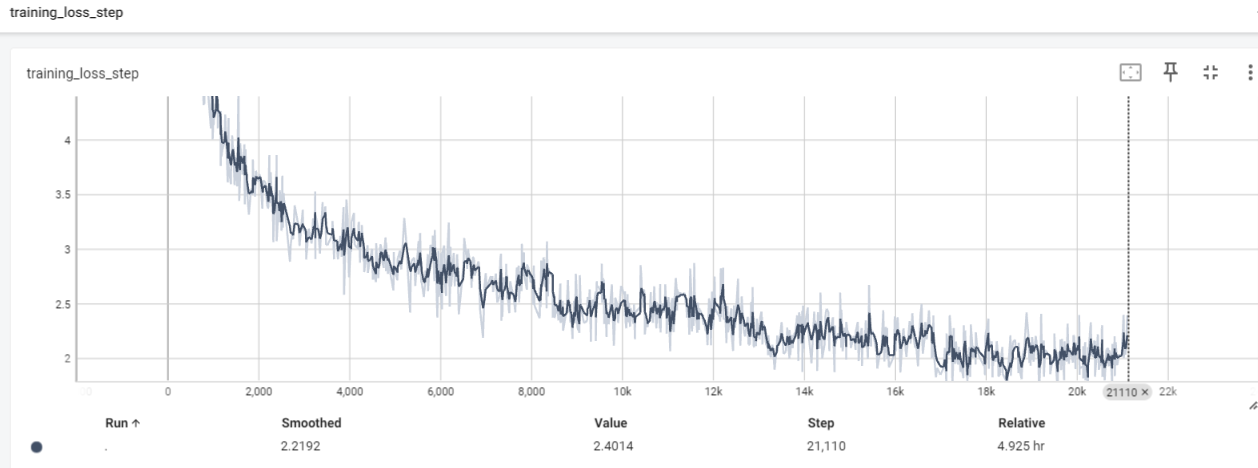

In [37]:
multimodel.eval()

VisionLanguageModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768

In [38]:
import torch.nn as nn


def generate(
    model: nn.Module,
    encoder_output: torch.Tensor,
    encoder_attention_mask: torch.Tensor,
    decoder_start: torch.Tensor,
    max_new_tokens=24,
    temperature=1.0,
    do_sample=False,
    top_k=10,
    use_cache=False,
) -> torch.Tensor:
    """

    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete

    the sequence max_new_tokens times, feeding the predictions back into the model each time.

    Most likely you'll want to make sure to be in model.eval() mode of operation for this.

    """
    idx = decoder_start

    idx_next = idx

    index = 0

    #     for cur_pos in range(min_promp, total_len)

    for _ in range(max_new_tokens):

        if use_cache:
            with torch.no_grad():
                logits = model(
                    encoder_output=encoder_output,
                    decoder_input_ids=idx_next,
                    use_cache=use_cache,
                    start_pos=index,
                ).logits
            logits = logits[:, -1] / temperature
        else:
            with torch.no_grad():
                logits = model(
                    encoder_output=encoder_output,
                    decoder_input_ids=idx,
                    #                     use_cache=use_cache,
                ).logits
            if index == 0:  # start token
                logits = logits[:, -1] / temperature
            else:
                logits = logits[:, -1, :] / temperature

        probs = torch.nn.functional.softmax(logits, dim=-1)

        # either sample from the distribution or take the most likely element

        if do_sample:

            idx_next = torch.multinomial(probs, num_samples=1)

        else:

            _, idx_next = torch.topk(probs, k=1, dim=-1)

        # append sampled index to the running sequence and continue

        idx = torch.cat((idx, idx_next), dim=1)

        index = idx.size()[1]  # model already have idx-1 kv-cache stored

    return idx

In [39]:
# multimodel.to(device)

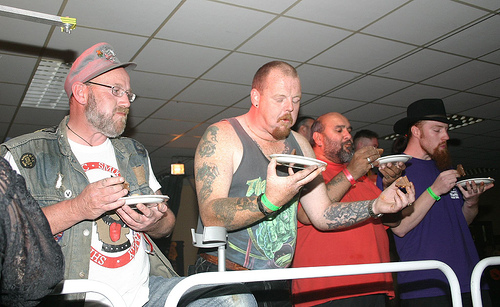

In [40]:
images = train_df["image"].values
img = Image.open(f"../input/flickr30k/Images/{images[0]}").convert("RGB")
img

In [41]:
# multimodel._clean_cache()
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A group of men are eating food and drinking.a. ". ". ". ". ". ".'

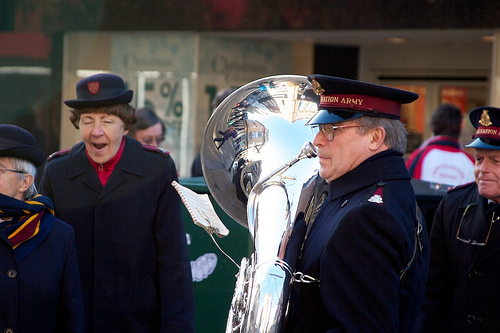

In [44]:
img = Image.open(f"../input/flickr30k/Images/{images[1]}").convert("RGB")
img

In [45]:
multimodel._clean_cache()
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> An older woman is standing in front of a band playing a saxophone. " sign. ". ". ".'

In [46]:
multimodel._clean_cache()
multimodel._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> An older woman is standing in front of a band playing a saxophone. " sign. ". ". ".'

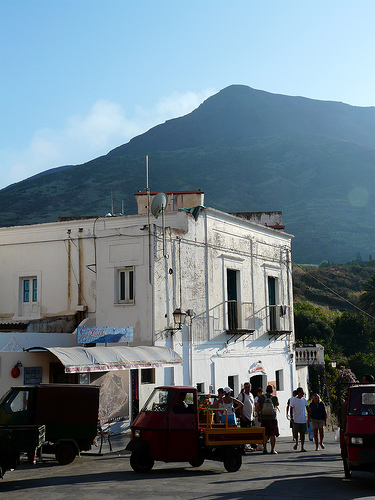

In [47]:
img = Image.open(f"../input/flickr30k/Images/{images[2]}").convert("RGB")
img

In [48]:
multimodel._clean_cache()
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A white car is parked in front of a white building. with a mountain in the background.`s. ".'

In [49]:
multimodel._clean_cache()
multimodel._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A white car is parked in front of a white building. with a mountain in the background.`s. ".'

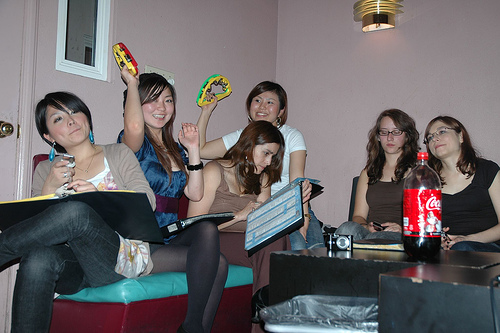

In [53]:
img = Image.open(f"../input/flickr30k/Images/{images[4]}").convert("RGB")
img

In [54]:
multimodel._clean_cache()
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A group of young women are sitting together and playing cards. " the same " one ". ". ". "'

In [55]:
multimodel._clean_cache()
multimodel._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A group of young women are sitting together and playing cards. " the same " one ". ". ". "'

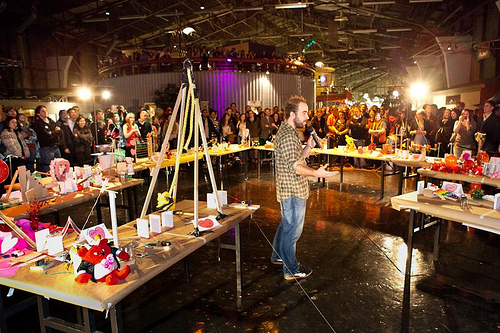

In [56]:
img = Image.open(f"../input/flickr30k/Images/{images[5]}").convert("RGB")
img

In [57]:
multimodel._clean_cache()
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A man in a brown jacket is standing in front of a crowd of people.`s, and a man in a'

In [58]:
multimodel._clean_cache()
multimodel._setup_cache(config)


pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A man in a brown jacket is standing in front of a crowd of people.`s, and a man in a'

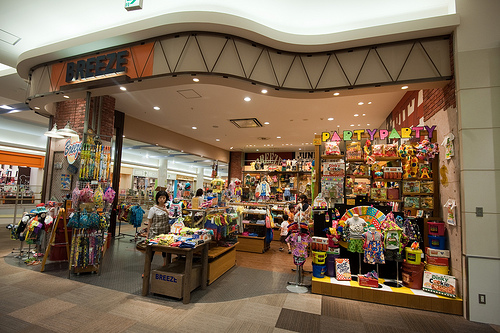

In [59]:
img = Image.open(f"../input/flickr30k/Images/{images[6]}").convert("RGB")
img

In [60]:
multimodel._clean_cache()
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A busy store with many people shopping.`s and shopping carts. " The Deep End ". ". ".'

In [61]:
multimodel._clean_cache()
multimodel._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A busy store with many people shopping.`s and shopping carts. " The Deep End ". ". ".'

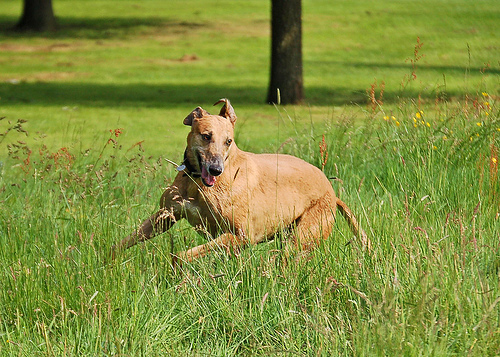

In [62]:
img = Image.open(f"../input/flickr30k/Images/{images[7]}").convert("RGB")
img

In [63]:
multimodel._clean_cache()
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A brown dog runs through a field of tall grass.`s. ". ". ". ". ".'

In [64]:
multimodel._clean_cache()
multimodel._setup_cache(config)


pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A brown dog runs through a field of tall grass.`s. ". ". ". ". ".'

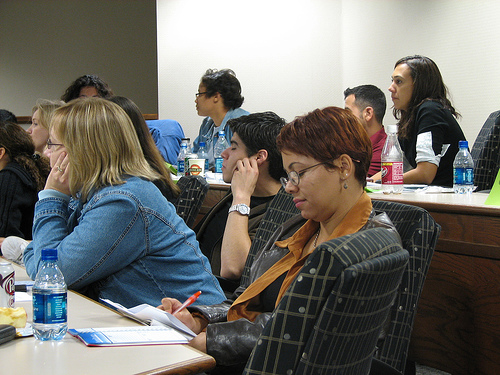

In [68]:
img = Image.open(f"../input/flickr30k/Images/{images[1]}").convert("RGB")
img

In [69]:
multimodel._clean_cache()
multimodel._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A group of people sitting at a table with computers.`s on the table. " I\'m ". "'

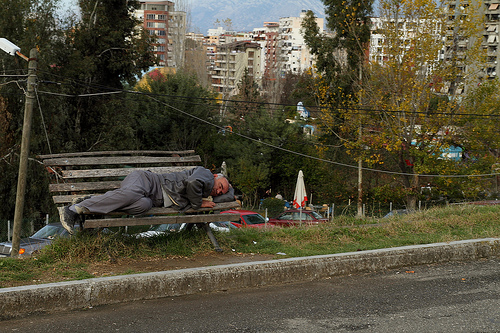

In [70]:
img = Image.open(f"../input/flickr30k/Images/{images[2]}").convert("RGB")
img

In [71]:
multimodel._clean_cache()
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A man is sleeping on a bench outside.`s a park bench. " The " I\'s ". "'

In [72]:
multimodel._clean_cache()
multimodel._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A man is sleeping on a bench outside.`s a park bench. " The " I\'s ". "'

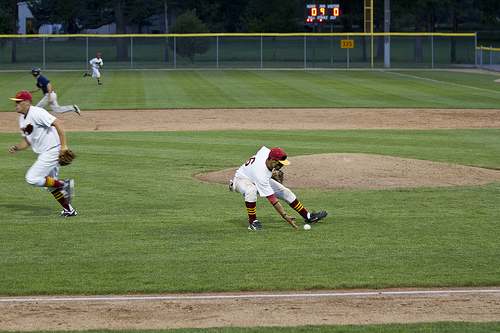

In [73]:
img = Image.open(f"../input/flickr30k/Images/{images[3]}").convert("RGB")
img

In [74]:
multimodel._clean_cache()
multimodel._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A baseball player in a red uniform is throwing the ball to a base while a catcher and umpire look on. "'

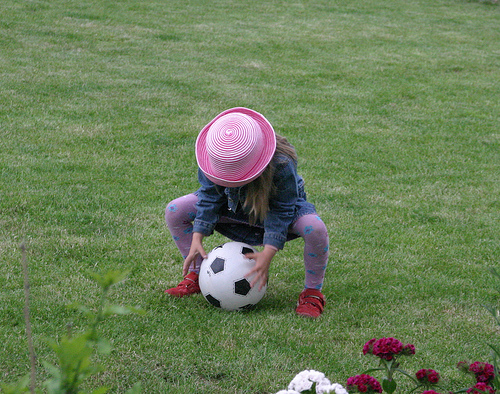

In [75]:
img = Image.open(f"../input/flickr30k/Images/{images[4]}").convert("RGB")
img

In [76]:
multimodel._clean_cache()
multimodel._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = multimodel.get_encoder_output(pixel_values=pixel_values)
# encoder_output = encoder_output = multimodel.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=multimodel,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A little girl in a pink hat and pink shirt playing with a soccer ball. " The word " on it. "'

**Much more to come on this topic**

